In [1]:
# Dependencies - General Stuff
import numpy as np
import importlib
import tempfile

# strfpy
from strfpy import preprocSound, strfSetup, trnDirectFit, calcSegmentedModel
from strfpy.timeFreq import timefreq_raw
from soundsig.sound import spec_colormap

import pynwb
from matplotlib import pyplot as plt
# %matplotlib widget
plt.ion()

#### Read the data file

In [2]:
# nwb_file = '/aquila_ssd2/lthomas/songephys_data/OperantEphys/HpiPur2667F/sites/HpiPur2667F_site02_240905_072851_pb_op/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'

nwb_file = '/Users/frederictheunissen/Working Data/OperantEphys/NWB_Files/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'
# Load the nwb file
preprocOptions = {} # we'll leave this empty and use default options
nwb_io =  pynwb.NWBHDF5IO(nwb_file, mode='r')
nwb = nwb_io.read()
units = nwb.units.to_dataframe()
# load the good units
good_units = units[units.group == 'good']


In [3]:
# sample a random unit
unit = good_units.sample().iloc[0]
unit = good_units.iloc[10]       # This is a good example for a neuron with strong onset-offset response - positive onset and negative offset
# unit = good_units.iloc[7]
print("Processing unit: ", unit.name)

Processing unit:  19


### Plot the stim and microphone data of a random playback trial

In [4]:
def get_mic_data(nwb, trial):
    rate = nwb.acquisition['audio'].rate
    mic_data = nwb.acquisition['audio'].data
    start_id = int(trial.start_time * rate)
    end_id = int(trial.stop_time * rate)
    mic_trial = mic_data[start_id:end_id]
    return mic_trial[:,1], mic_trial[:,0]

In [5]:
# lets take one trial and compare the spectrogram to the spectrogram of the microphone data
# lets get a ranodm trial
trials = nwb.intervals['playback_trials'].to_dataframe()

Repeat the cell below to get another example

A colormap named "SpectroColorMap" is already registered.


Text(0.5, 0, 'Time (s)')

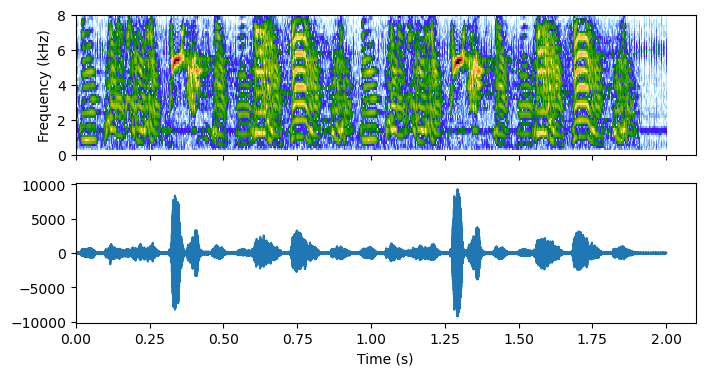

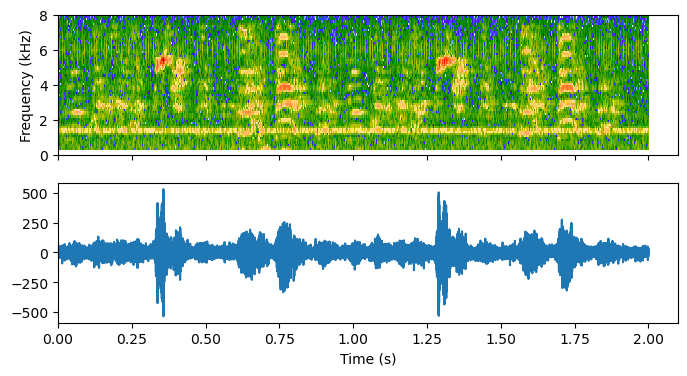

In [6]:
# Choose a ramdom trial
trial = trials.sample().iloc[0]
mic_trial, mic_copy = get_mic_data(nwb, trial)
rate = nwb.acquisition['audio'].rate

# Spectrogram paramteters.
stim_params = {}
stim_params['fband'] = 120
stim_params['nstd'] = 6
stim_params['high_freq'] = 8000
stim_params['low_freq'] = 250
stim_params['log'] = 1
stim_params['stim_rate'] = 1000  # Sample rate of spectrogram
DBNOISE = 80
# Colormap for plotting spectrograms
spec_colormap()   # defined in sound.py


# First figure for the microphone copy
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_copy, rate, 'ft', params=stim_params)
cmap = plt.get_cmap('SpectroColorMap')

minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_copy))/rate
ax2.plot(tval, mic_copy)
ax2.set_xlabel('Time (s)')

# Second copy for the microphone 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

tfrep = timefreq_raw(mic_trial, rate, 'ft', params=stim_params)
minSpect = tfrep['spec'].max()-DBNOISE
maxB = tfrep['spec'].max()
ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

tval = np.arange(stop=len(mic_trial))/rate
ax2.plot(tval, mic_trial)
ax2.set_xlabel('Time (s)')



#### Create an stimulus-response data set (srData) per stimlus

In [7]:
# Preprocess sound stimulus and segment

respChunkLen = 100 # ms of stim to use in each chunk of feature space
segmentBuffer = 30 # ms to add at the beginning of each segment
nLaguerre = 25 # number of laguerre functions to use
feature = 'spect_windows'
event_types = 'onoff_feature'
nPoints = 150 # number of points to use in the kernel

srData = preprocSound.preprocess_sound_nwb(nwb_file, 'playback_trials', unit.name, preprocess_type='ft')
calcSegmentedModel.preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False)

print('This playback stim-response data set has %d stimuli.' % (len(srData['datasets'])))


              kilosort_dir  kilosort_id group       ks_x        ks_y  \
id                                                                     
19  ks4_lat_250215/shank_0           38  good  11.247663  223.116302   

                                          spike_times electrodes  
id                                                                
19  [0.24823333333333333, 0.25783333333333336, 0.4...        [3]  


/Users/frederictheunissen/Code/strfPy/module/strfpy/timeFreq.py:29: RuntimeWarning: divide by zero encountered in log10
  normedS = 20 * np.log10(normedS)


This playback stim-response data set has 41 stimuli.


In [8]:
# Estimate the single trial SNR for this data set
snr = preprocSound.estimate_SNR(srData)
print('The single trial SNR is %.4f' % (snr))
print('The corresponding EV for 10 trials is %.4f' % (10*snr/(10*snr + 1)))

The single trial SNR is 1.1637
The corresponding EV for 10 trials is 0.9209


In [9]:
# Calculate the average response at onsets and offsets

meansOnOff = np.zeros((2,nPoints))
nEventsOnOff = np.zeros((2,nPoints))
responseAvg = 0
stimLenTot = 0
for ds in srData['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    y = ds['resp']['psth_smooth']
    if "weights" not in ds["resp"]:
        yw = np.ones_like(y)
    else:
        yw =ds["resp"]["weights"]
    y = y[yw > 0]
    yw = yw[yw > 0]

    responseAvg += np.sum(y*yw)
    stimLenTot += np.sum(yw)
    stimLen = len(yw)
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]        
        if (startInd >= stimLen):
            break

        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
            
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff[0,0:endInd-startInd] = meansOnOff[0,0:endInd-startInd] + y[startInd:endInd]*yw[startInd:endInd]
            nEventsOnOff[0,0:endInd-startInd] += yw[startInd:endInd]
        else:
            meansOnOff[1,0:endInd-startInd] = meansOnOff[1,0:endInd-startInd] + y[startInd:endInd]*yw[startInd:endInd]
            nEventsOnOff[1,0:endInd-startInd] += yw[startInd:endInd]

meansOnOff[0,:] /= nEventsOnOff[0,:]
meansOnOff[1,:] /= nEventsOnOff[1,:]
responseAvg /= stimLenTot

meansOnOff[0,:] -= responseAvg
meansOnOff[1,:] -= responseAvg




In [10]:
importlib.reload(calcSegmentedModel)

<module 'strfpy.calcSegmentedModel' from '/Users/frederictheunissen/Code/strfPy/module/strfpy/calcSegmentedModel.py'>

In [11]:
# Fit the segmentation (on-off here) kernel (impulse response)
segModel = calcSegmentedModel.fit_seg(srData, nPoints, x_feature = event_types, y_feature = 'psth_smooth', kernel = 'Kernel', nD=2, tol=np.array([0.1, 0.01, 0.001, 0.0001]), store_error = True )
learned_conv_kernel = segModel['weights'].reshape(2, nPoints)

In [12]:
raw_kernel = segModel['Cxy'].reshape(2, nPoints)
b0 = segModel['b0']
Cxx = segModel['Cxx']

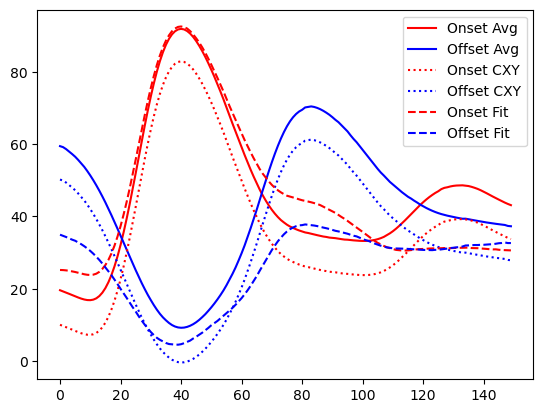

In [13]:
# Checking to see if our normalization works properfly

plt.plot(meansOnOff[0,:]+responseAvg, 'r', label='Onset Avg')
plt.plot(meansOnOff[1,:]+responseAvg, 'b', label='Offset Avg')
plt.plot(raw_kernel[0,:]*1/np.diag(Cxx)[0:nPoints]+b0, 'r:', label='Onset CXY')
plt.plot(raw_kernel[1,:]*1/np.diag(Cxx)[nPoints:]+b0, 'b:', label='Offset CXY')
plt.plot(learned_conv_kernel[0,:]+b0, 'r--', label='Onset Fit')
plt.plot(learned_conv_kernel[1,:]+b0, 'b--', label='Offset Fit')
plt.legend()


In [14]:
# Fit the segmentation (on-off here) kernel2 (impulse response with alternative matrix inversion)
segModel2 = calcSegmentedModel.fit_seg(srData, nPoints, x_feature = event_types, y_feature = 'psth_smooth', kernel = 'Kernel2', nD=2, tol=np.array([10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]), store_error = True )
learned_conv_kernel2 = segModel2['weights'].reshape(2, nPoints)

In [15]:
raw_kernel2 = segModel2['Cxy'].reshape(2, nPoints)
b0_2 = segModel2['b0']
Cxx_2 = segModel2['Cxx']

In [16]:
print(segModel['R2CV'])
print(segModel2['R2CV'])

[0.35523906 0.36096506 0.36098112 0.36096934]
[0.35667693 0.36092131 0.36097313 0.3609685  0.36096793 0.36096787]


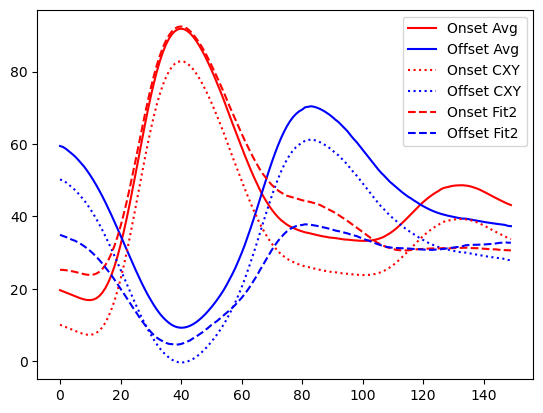

In [17]:
# Checking to see if our normalization works properfly

plt.plot(meansOnOff[0,:]+responseAvg, 'r', label='Onset Avg')
plt.plot(meansOnOff[1,:]+responseAvg, 'b', label='Offset Avg')
plt.plot(raw_kernel2[0,:]*1/np.diag(Cxx)[0:nPoints]+b0_2, 'r:', label='Onset CXY')
plt.plot(raw_kernel2[1,:]*1/np.diag(Cxx)[nPoints:]+b0_2, 'b:', label='Offset CXY')
plt.plot(learned_conv_kernel2[0,:]+b0_2, 'r--', label='Onset Fit2')
plt.plot(learned_conv_kernel2[1,:]+b0_2, 'b--', label='Offset Fit2')
plt.legend()

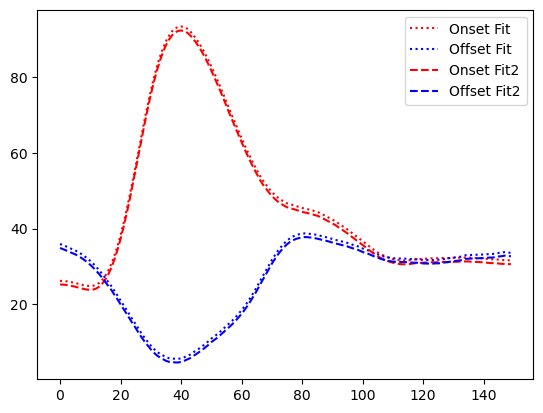

In [18]:
plt.plot(learned_conv_kernel[0,:]+1+b0, 'r:', label='Onset Fit')
plt.plot(learned_conv_kernel[1,:]+1+b0, 'b:', label='Offset Fit')
plt.plot(learned_conv_kernel2[0,:]+b0_2, 'r--', label='Onset Fit2')
plt.plot(learned_conv_kernel2[1,:]+b0_2, 'b--', label='Offset Fit2')
plt.legend()

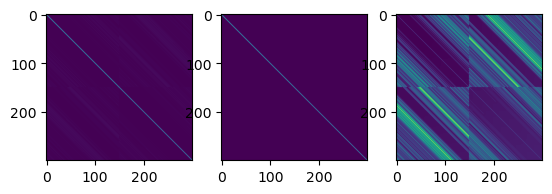

In [19]:
# Make plots of stimulus autocorrelation matrix for figures, etc
Cxx = segModel['Cxx']
Cxx_corr = Cxx - np.diag(np.diag(Cxx))
plt.subplot(1,3,1)
plt.imshow(Cxx)
plt.subplot(1,3,2)
plt.imshow(np.diag(np.diag(Cxx)))
plt.subplot(1,3,3)
plt.imshow(Cxx_corr)


Norm of offdiagonal correction 0.015365


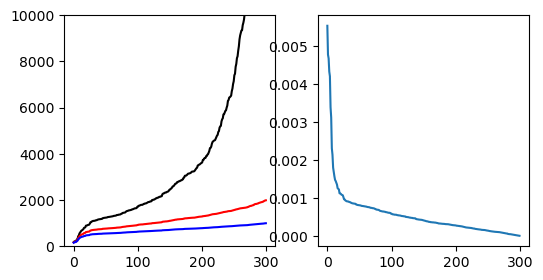

In [20]:
u, s, v = np.linalg.svd(Cxx_corr)
print('Norm of offdiagonal correction %f' % np.linalg.norm(Cxx_corr))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(1/s, 'k')
plt.plot(1/(s + 0.0005), 'r')
plt.plot(1/(s + 0.001), 'b')
plt.ylim((0,10000))
plt.subplot(1,2,2)
plt.plot(s)

Norm of Cxx 0.125733


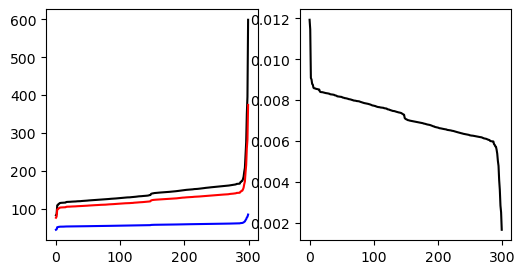

In [21]:
ua, sa, va = np.linalg.svd(Cxx)
print('Norm of Cxx %f' % np.linalg.norm(Cxx))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(1/sa, 'k')
plt.plot(1/(sa + 0.001), 'r')
plt.plot(1/(sa + 0.01), 'b')
plt.subplot(1,2,2)
plt.plot(sa, 'k')


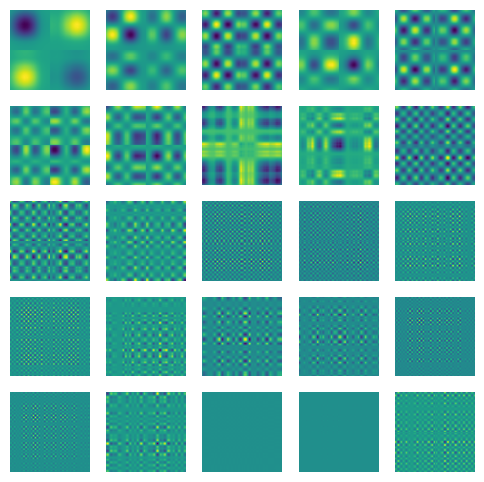

In [22]:
nPlots = 25
plt.figure(figsize=(6,6))
for ip in range(nPlots):
    plt.subplot(5,5, ip+1)
    u0 = np.reshape(u[:,ip], (u.shape[0], 1))
    v0 = np.reshape(v[ip,:], (1, v.shape[1]))
    Cxx_corrD = (u0@v0)*s[ip]
    ax = plt.imshow(Cxx_corrD)
    ax.axes.set_axis_off()



1.0015831577253522


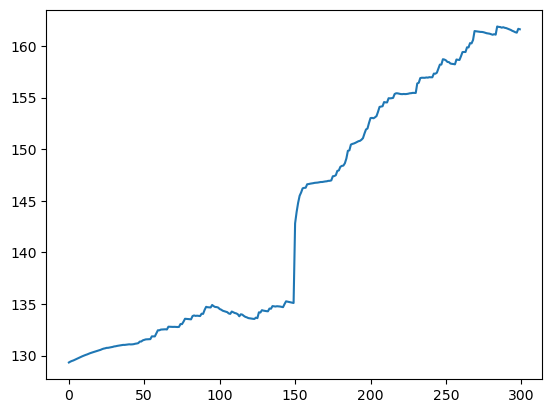

In [23]:
Cxx_inv = calcSegmentedModel.nearDiagInv(np.diag(np.diag(Cxx)), u, s, v, tol=0.01*np.linalg.norm(Cxx_corr) )
itest = Cxx_inv@Cxx
print(np.max(itest))
plt.plot(np.diag(Cxx_inv))

In [24]:
# Fit the on-off kernels with laguerre and DOGs
laguerre_args = calcSegmentedModel.fit_kernel_LG(learned_conv_kernel, nPoints, nD=2)
DOGS_args = calcSegmentedModel.fit_kernel_DG(learned_conv_kernel, nPoints, nD=2)

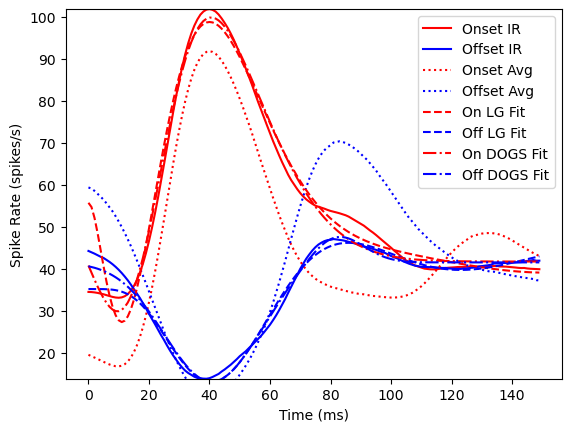

In [25]:
# Plot the segmented Kernels for this neuron and the laguerre fits
b0 = segModel['yavg']
nt = learned_conv_kernel.shape[1]
x_t = np.arange(nt)
nLGFit = laguerre_args.shape[1]-2
yOnFitLG = np.ones(nt)*np.mean(learned_conv_kernel[0,:])
for iLG in range(nLGFit):
        yOnFitLG += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[0,2+iLG], tau=laguerre_args[0,0], alpha=laguerre_args[0,1], xorder=iLG)

yOffFitLG = np.ones(nt)*np.mean(learned_conv_kernel[1,:])
for iLG in range(nLGFit):
        yOffFitLG += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[1,2+iLG], tau=laguerre_args[1,0], alpha=laguerre_args[1,1], xorder=iLG)

yOnDOGFit = calcSegmentedModel.dogs(np.arange(nt), *DOGS_args[0,:])
yOffDOGFit = calcSegmentedModel.dogs(np.arange(nt), *DOGS_args[1,:])

plt.figure()

plt.plot(learned_conv_kernel[0,:]+b0, 'r', label='Onset IR')
plt.plot(learned_conv_kernel[1,:]+b0, 'b', label='Offset IR')
plt.plot(meansOnOff[0,:]+responseAvg, 'r:', label='Onset Avg')
plt.plot(meansOnOff[1,:]+responseAvg, 'b:', label='Offset Avg')
plt.plot(yOnFitLG+b0, 'r--', label='On LG Fit')
plt.plot(yOffFitLG+b0, 'b--', label='Off LG Fit')
plt.plot(yOnDOGFit+b0, 'r-.', label='On DOGS Fit')
plt.plot(yOffDOGFit+b0, 'b-.', label='Off DOGS Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.ylim((np.min(learned_conv_kernel+b0), np.max(learned_conv_kernel+b0)))
plt.legend()

Tau = 17.97 Alpha = 2.04


Text(0, 0.5, 'Spike Rate (spikes/s)')

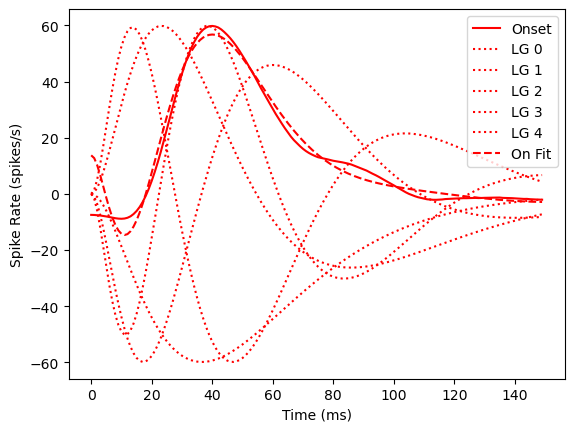

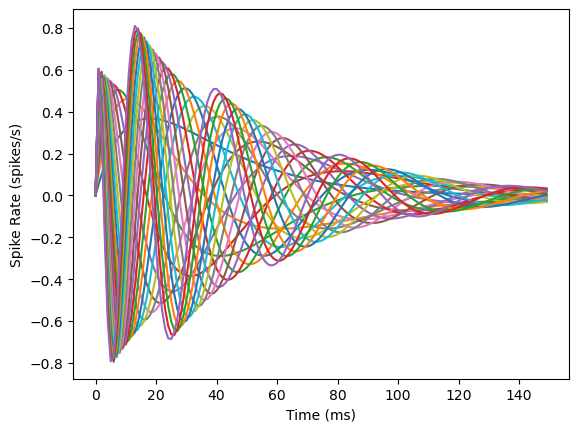

In [26]:
# Show how the fit is done for the LG - note that it is even worse than it looks because basis fit componnents are scaled.
nt = learned_conv_kernel.shape[1]
x_t = np.arange(nt)
nLGFit = laguerre_args.shape[1]-2
yOnFit = np.ones(nt)*np.mean(learned_conv_kernel[0,:])
plt.plot(learned_conv_kernel[0,:], 'r', label='Onset')
for iLG in range(nLGFit):
        yLG = calcSegmentedModel.laguerre(x_t, amp=laguerre_args[0,2+iLG], tau=laguerre_args[0,0], alpha=laguerre_args[0,1], xorder=iLG)
        yOnFit += yLG
        plt.plot(yLG*np.max(np.abs(learned_conv_kernel[0,:]))/np.max(np.abs(yLG)), 'r:', label='LG %d'%(iLG))

plt.plot(yOnFit, 'r--', label='On Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.legend()

plt.figure()
for iL in range(nLaguerre):
    yLG = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=laguerre_args[0,0],
        alpha=1,   # laguerre_args[0,1]
        xorder=iL,
        )
    plt.plot(yLG)
        
print('Tau = %.2f Alpha = %.2f' % (laguerre_args[0,0], laguerre_args[0,1]) )
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')

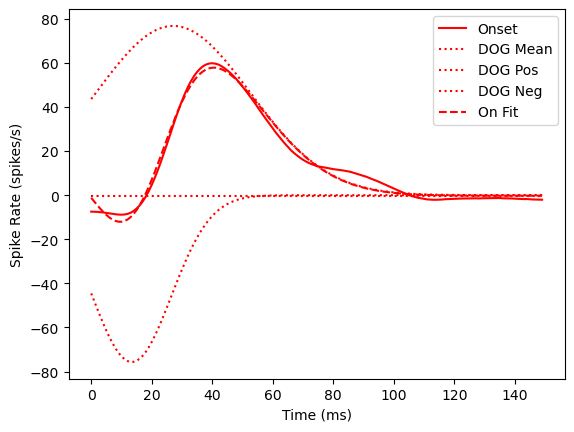

In [27]:
# Show how the fit is done for the DOGS 
nt = learned_conv_kernel.shape[1]
x_t = np.arange(nt)
nDOGS = 5

plt.plot(learned_conv_kernel[0,:], 'r', label='Onset')

meanValOn, ampPosOn, ampNegOn, tPosOn, tNegOn, sdPosOn, sdNegOn = DOGS_args[0]  

yOnFit = np.ones(nt)*meanValOn  
plt.plot(yOnFit, 'r:', label='DOG Mean')
yDG = ampPosOn*calcSegmentedModel.Gauss(x_t, tPosOn, sdPosOn)
plt.plot(yDG, 'r:', label='DOG Pos')
yOnFit += yDG
yDG = -ampNegOn*calcSegmentedModel.Gauss(x_t, tNegOn, sdNegOn)
plt.plot(yDG, 'r:', label='DOG Neg')
yOnFit += yDG

plt.plot(yOnFit, 'r--', label='On Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.legend()



In [28]:
# first use PCA to reduce dim of the features'
pca_spect = calcSegmentedModel.generate_event_pca_feature(srData, event_types, feature, pca = None, npcs=20)

### The Segmented Laguerre

In [29]:
# Calculate the segmented encoding models for spectrograms and Laguerre.
nLaguerre = 20
segIDModelLG = calcSegmentedModel.fit_seg(srData, nPoints, feature, y_feature = 'error_Kernel', y_R2feature = 'psth_smooth', kernel = 'LG', basis_args =laguerre_args, nD=nLaguerre) 

print('Laguerre model based on segmented Log Spect on PSHT')
print('R2 CV for Seg: %.4f' % (np.max(segModel['R2CV'])))
print('R2 CV for Seg+Id: %.4f' % (np.max(segIDModelLG['R2CV'])))
evOne= snr/(snr + 1)
print('EV on 1 trial: %.4f' % (evOne))



Laguerre model based on segmented Log Spect on PSHT
R2 CV for Seg: 0.3610
R2 CV for Seg+Id: 0.3808
EV on 1 trial: 0.5378


### The Segmented DOGS

In [30]:
# Calculate the segmented encoding models for spectrograms and DOGS.
nDOGS = 5
segIDModelDG = calcSegmentedModel.fit_seg(srData, nPoints, feature, y_feature = 'error_Kernel', y_R2feature = 'psth_smooth', kernel = 'DG', basis_args =DOGS_args, nD=nDOGS) 

print('DOGS model based on segmented Log Spect on PSHT')
print('R2 CV for Seg: %.4f' % (np.max(segModel['R2CV'])))
print('R2 CV for Seg+Id: %.4f' % (np.max(segIDModelDG['R2CV'])))
evOne= snr/(snr + 1)
print('EV on 1 trial: %.4f' % (evOne))

DOGS model based on segmented Log Spect on PSHT
R2 CV for Seg: 0.3610
R2 CV for Seg+Id: 0.3835
EV on 1 trial: 0.5378


### The classic STRF

In [31]:
# For debugging
from strfpy import strfSetup, calcAvg, calcAutoCorr, calcCrossCorr, calcStrf_script 

In [32]:
# For debugging
importlib.reload(strfSetup)
importlib.reload(calcAvg)
importlib.reload(calcAutoCorr)
importlib.reload(calcCrossCorr)
importlib.reload(calcStrf_script)

<module 'strfpy.calcStrf_script' from '/Users/frederictheunissen/Code/strfPy/module/strfpy/calcStrf_script.py'>

In [56]:
# Initialize the linear time invariant model. Here we choose 100 delay points 
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']
strfLength = 200
strfDelays = np.arange(strfLength)
modelParams = strfSetup.linInit(nStimChannels, strfDelays)

# Convert srData into a format that strflab understands
allstim, allresp, allweights, groupIndex = strfSetup.srdata2strflab(srData, useRaw = False)
globDat = strfSetup.strfData(allstim, allresp, allweights, groupIndex)

# Additional model options
modelParams['funcName'] = 'trnDirectFit'
modelParams['Tol_val'] = [0.100, 0.050, 0.010, 0.005, 1e-03, 1e-04, 5e-05, 0]
modelParams['sparsenesses'] = [0, 1, 2, 3, 4, 5, 6, 7]
modelParams['setSep'] = 0
modelParams['timevary_PSTH'] = 0
modelParams['smooth_rt'] = 31
modelParams['ampsamprate'] = 1000
modelParams['respsamprate'] = 1000
modelParams['infoFreqCutoff'] = 100
modelParams['infoWindowSize'] = 0.250
modelParams['TimeLagUnit'] = 'frame'
modelParams['use_alien_space'] = 0
modelParams['alien_space_file'] = ''
modelParams['outputPath'] = tempfile.gettempdir()
modelParams['TimeLag'] =  int(np.ceil(np.max(np.abs(modelParams['delays']))))
modelParams['display'] = 1


In [57]:
# Run direct fit optimization on all of the data
modelParams = trnDirectFit.trnDirectFit(modelParams, globDat)

Now calculating stim auto-correlation
The auto-correlation took 117.53713199999993 seconds.
Now calculating stim-response cross-correlation
Now doing cross-correlation calculation.
Done calculation of cross-correlation.
Now calculating JN cross-correlation.
Done calculation of JN cross-correlation.
The cross-correlation took 2.9363270000003467 seconds.
Calculating strfs for each tol value.
Done df_fft_AutoCrossCorr.
Calculating STRF for each tol value...
Now calculating STRF for tol_value: 0.1
Done calculation of STRF for tol_value: 0.1

Now calculating STRF for tol_value: 0.05
Done calculation of STRF for tol_value: 0.05

Now calculating STRF for tol_value: 0.01
Done calculation of STRF for tol_value: 0.01

Now calculating STRF for tol_value: 0.005
Done calculation of STRF for tol_value: 0.005

Now calculating STRF for tol_value: 0.001
Done calculation of STRF for tol_value: 0.001

Now calculating STRF for tol_value: 0.0001
Done calculation of STRF for tol_value: 0.0001

Now calculati

/Users/frederictheunissen/Code/strfPy/module/strfpy/trnDirectFit.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  R2CV[k,q] = 1.0 - y_error/y_var


Tolerance=0.1, Sparseness=0, Avg. Prediction Info=[18.33667712], R2CV=-0.5200000724546712
Tolerance=0.1, Sparseness=1, Avg. Prediction Info=[18.66207611], R2CV=-0.4699250523619207
Tolerance=0.1, Sparseness=2, Avg. Prediction Info=[18.8051106], R2CV=-0.39258240122733756
Tolerance=0.1, Sparseness=3, Avg. Prediction Info=[18.77618621], R2CV=-0.2628154860696943
Tolerance=0.1, Sparseness=4, Avg. Prediction Info=[19.12127269], R2CV=-0.06580619013638178
Tolerance=0.1, Sparseness=5, Avg. Prediction Info=[20.92828672], R2CV=0.17473665154116724
Tolerance=0.1, Sparseness=6, Avg. Prediction Info=[23.54314398], R2CV=0.3230514134183142
Tolerance=0.1, Sparseness=7, Avg. Prediction Info=[27.05977383], R2CV=0.3564962711377402
Tolerance=0.05, Sparseness=0, Avg. Prediction Info=[14.82355731], R2CV=-5.027984961397479
Tolerance=0.05, Sparseness=1, Avg. Prediction Info=[15.04867086], R2CV=-4.741380658832242
Tolerance=0.05, Sparseness=2, Avg. Prediction Info=[15.15610103], R2CV=-4.190710072925531
Tolerance=0

In [35]:
modelParams.keys()

dict_keys(['type', 'nIn', 'nWts', 'delays', 'w1', 'b1', 'outputNL', 'freqDomain', 'internal', 'funcName', 'Tol_val', 'sparsenesses', 'setSep', 'timevary_PSTH', 'smooth_rt', 'ampsamprate', 'respsamprate', 'infoFreqCutoff', 'infoWindowSize', 'TimeLagUnit', 'use_alien_space', 'alien_space_file', 'outputPath', 'TimeLag', 'display', 'DS', 'NBAND', 'CS', 'CS_JN', 'CSR', 'CSR_JN', 'R2CV', 'stimAvg'])

In [36]:
from scipy.signal import correlate, correlation_lags

In [58]:
stimB0 = allstim[:,0]
meanB0 = np.sum(stimB0*allweights)/np.sum(allweights)
meanR = np.sum(allresp*allweights)/np.sum(allweights)

ngroups = int(groupIndex.max()+1)
CS = np.zeros(399)
CSR = np.zeros(399)
CS_count = np.zeros(399)
CSR_count = np.zeros(399)

for igroup in range(ngroups):
    stimG = stimB0[groupIndex == igroup]
    respG = allresp[groupIndex == igroup]
    weightG = np.sqrt(allweights[groupIndex == igroup])

    corrSS = correlate((stimG-meanB0)*weightG, (stimG-meanB0)*weightG, mode="full")
    corrSR = correlate((stimG-meanB0), (respG-meanR)*weightG**2, mode="full")
    lags = correlation_lags(stimG.size, stimG.size, mode="full")
    xcorr_res = correlate(weightG, weightG, mode='full')
    xcorr_res2 = correlate(np.ones_like(weightG), weightG**2, mode='full')
    
    itlow = np.argwhere(lags == -199)[0][0]
    ithigh = np.argwhere(lags == 199)[0][0]+1

    CS += corrSS[itlow:ithigh]
    CSR += corrSR[itlow:ithigh]
    CS_count += xcorr_res[itlow:ithigh]
    CSR_count += xcorr_res2[itlow:ithigh]

CS /= CS_count
CSR /= CSR_count



Text(0.5, 1.0, 'Cross-correlation')

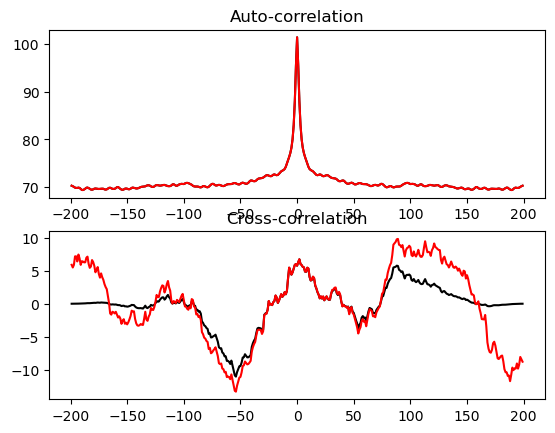

In [59]:
# Check the scale of the auto-correlation and cross-correlation

plt.subplot(2,1,1)
plt.plot(np.linspace(start= -199, stop= 199, num=399 ), modelParams['CS'][0], 'k')
plt.plot(np.linspace(start= -199, stop= 199, num=399 ), CS, 'r')
plt.title('Auto-correlation')
plt.subplot(2,1,2)
plt.plot(np.linspace(start= -199, stop= 199, num=399 ), modelParams['CSR'][0], 'k')
plt.plot(np.linspace(start= -199, stop= 199, num=399 ), CSR, 'r')
plt.title('Cross-correlation')


Text(0.5, 1.0, 'Best STRF')

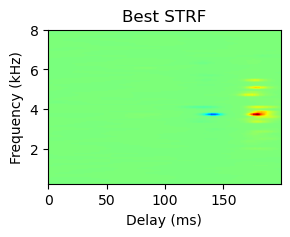

In [60]:
# display the best STRF
plt.figure(figsize=(3,2), dpi=100)

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']

mySTRF = np.real(modelParams['w1'])
maxabs = np.max(np.abs(mySTRF))

plt.imshow( np.fliplr(mySTRF), origin='lower', cmap = 'jet', aspect='auto',
           extent=[strfDelays[0], strfDelays[-1], strfFrequencies[0]*1e-3, strfFrequencies[-1]*1e-3],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (kHz)')
plt.title('Best STRF')

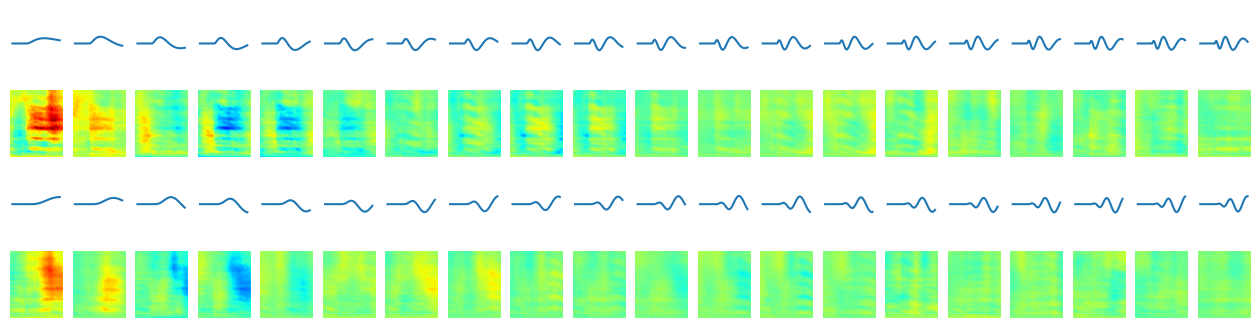

In [42]:
# Plot the On and Off filters for Laguerre Fit

# Get the sectrogram size
events = srData['datasets'][0]['events']
nf = events[feature].shape[1]
nt = events[feature].shape[2]
npcs = pca_spect.n_components_

plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nLaguerre, nf, nt))
strfLGOff = np.zeros((nLaguerre, nf, nt))
x_t = np.arange(nt-segmentBuffer)
x_plot = np.arange(nt)-segmentBuffer


for iL in range(nLaguerre):
    istart = 2*npcs*iL
    iend = istart+npcs
    strfLGOn[iL,:,:] = np.dot(segIDModelLG['weights'][istart:iend], pca_spect.components_).reshape((nf,nt))
    strfLGOff[iL,:,:] = np.dot(segIDModelLG['weights'][istart+npcs:iend+npcs], pca_spect.components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))
                 
for iL in range(nLaguerre):
    yOn = np.zeros(nt)
    yOn[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=laguerre_args[0,0],
        alpha=laguerre_args[0,1],
        xorder=iL,
        )
    yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = np.zeros(nt)
    yOff[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=laguerre_args[1,0],
        alpha=laguerre_args[1,1],
        xorder=iL,
        )
    yOff = yOff / np.sqrt(np.sum(yOff**2))
    plt.subplot(4,  nLaguerre, iL+1)
    plt.plot(x_plot,yOn)
    plt.ylim((-1,1))
    plt.axis('off')
    plt.subplot(4,  nLaguerre, 2*nLaguerre+iL+1)
    plt.plot(x_plot,yOff)
    plt.ylim((-1,1))
    plt.axis('off')
    plt.subplot(4, nLaguerre, nLaguerre+iL+1)
    plt.imshow(strfLGOn[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')
    plt.subplot(4, nLaguerre, 3*nLaguerre+iL+1)
    plt.imshow(strfLGOff[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')



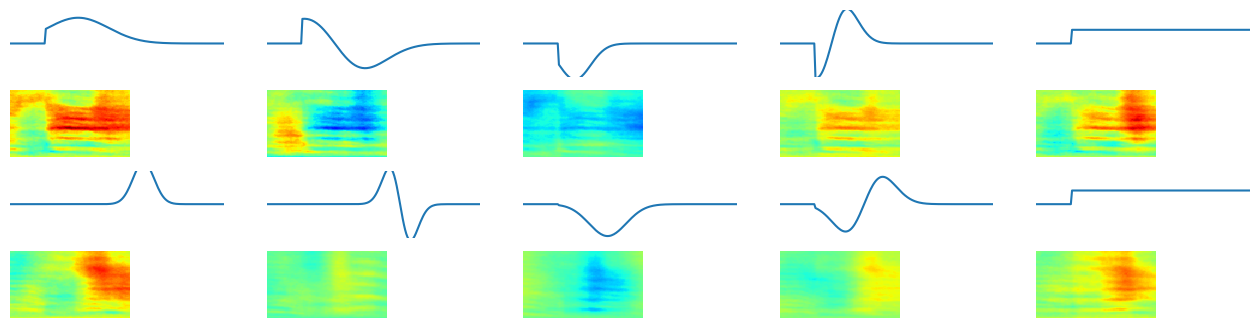

In [43]:
# Plot the On and Off filters for the DOGS Fit

plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nDOGS, nf, nt))
strfLGOff = np.zeros((nDOGS, nf, nt))
x_t = np.arange(nPoints)
x_plot = np.arange(nPoints+segmentBuffer)-segmentBuffer


for iD in range(nDOGS):
    istart = 2*npcs*iD
    iend = istart+npcs
    strfLGOn[iD,:,:] = np.dot(segIDModelDG['weights'][istart:iend], pca_spect.components_).reshape((nf,nt))
    strfLGOff[iD,:,:] = np.dot(segIDModelDG['weights'][istart+npcs:iend+npcs], pca_spect.components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))

meanValOn, ampPosOn, ampNegOn, tPosOn, tNegOn, sdPosOn, sdNegOn = DOGS_args[0]   
meanValOff, ampPosOff, ampNegOff, tPosOff, tNegOff, sdPosOff, sdNegOff = DOGS_args[1]                
for iD in range(nDOGS):
    yOn = np.zeros(nPoints+segmentBuffer) 
    yOff = np.zeros(nPoints+segmentBuffer)           
    if (iD == 0) :
        yOn[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOff, sdPosOff)
    elif (iD == 1) : 
        yOn[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOff, sdPosOff)
    elif (iD == 2) : 
        yOn[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOff, sdNegOff)
    elif (iD ==3) :
        yOn[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOff, sdNegOff)
    elif (iD == 4):
        yOn[segmentBuffer:] = np.ones(nPoints)
        yOff[segmentBuffer:] = np.ones(nPoints)
    
    yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = yOff / np.sqrt(np.sum(yOff**2))

    plt.subplot(4,  nDOGS, iD+1)
    plt.plot(x_plot,yOn)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4,  nDOGS, 2*nDOGS+iD+1)
    plt.plot(x_plot,yOff)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4, nDOGS, nDOGS+iD+1)
    plt.imshow(strfLGOn[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')
    plt.subplot(4, nDOGS, 3*nDOGS+iD+1)
    plt.imshow(strfLGOff[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')



/Users/frederictheunissen/anaconda3/envs/ephys/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/frederictheunissen/anaconda3/envs/ephys/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_1849/94316689.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  ax2.set_title('MSE_0 = %.2f MSE_Seg = %.2f MSE_SegLG = %.2f MSE_DG = %.2f MSE_STRF = %.2f' % (mse_0, mse_1, mse_2, mse_3, mse_4))
/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_1849/94316689.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warni

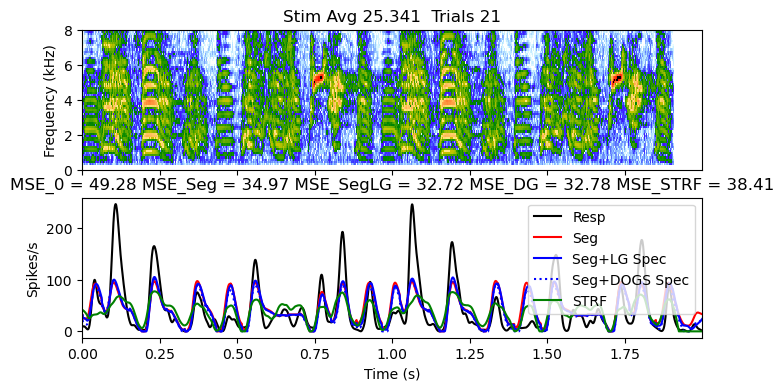

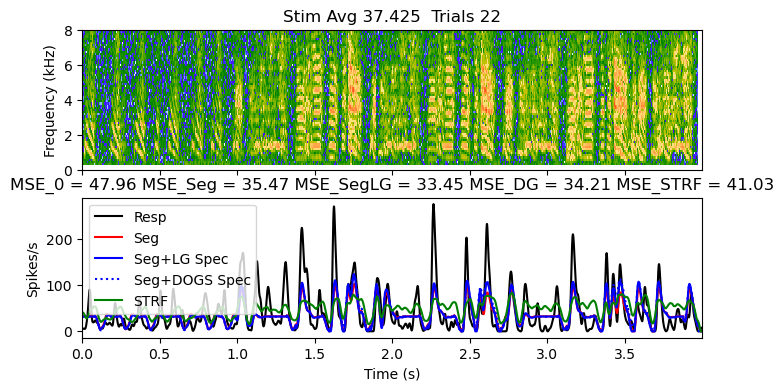

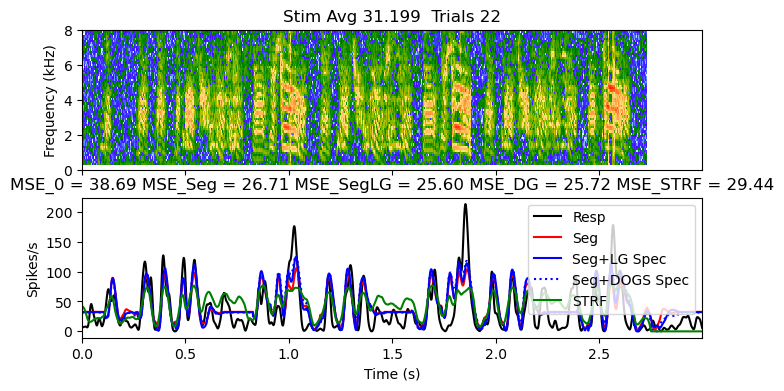

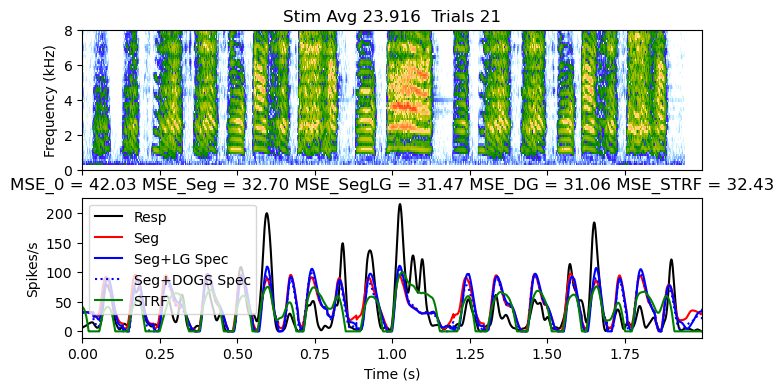

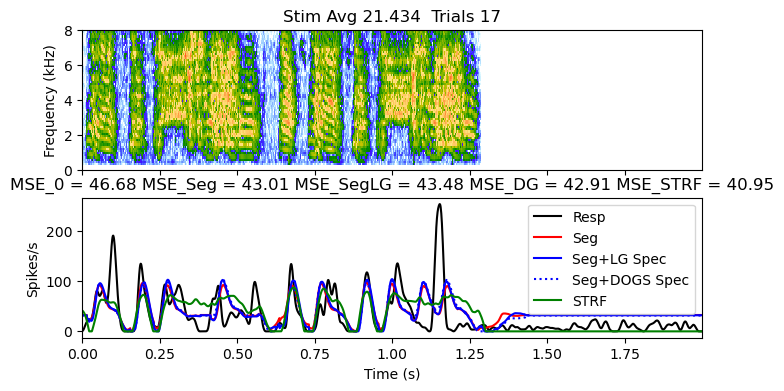

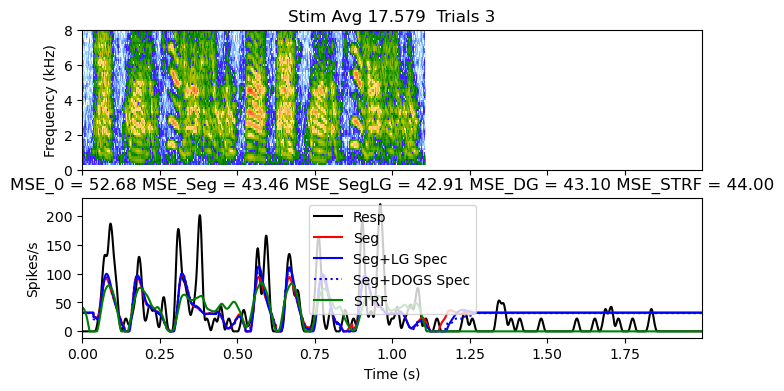

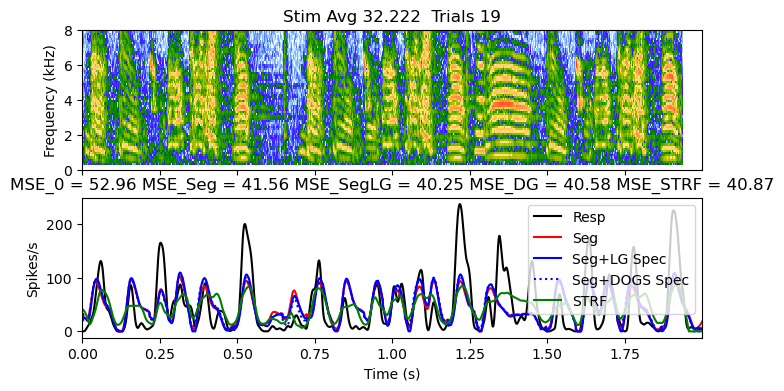

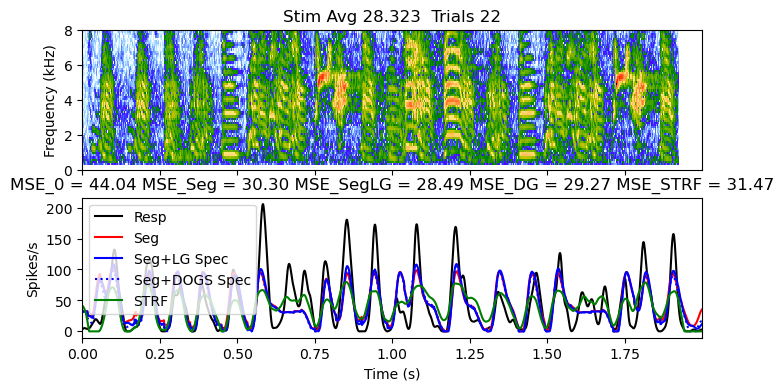

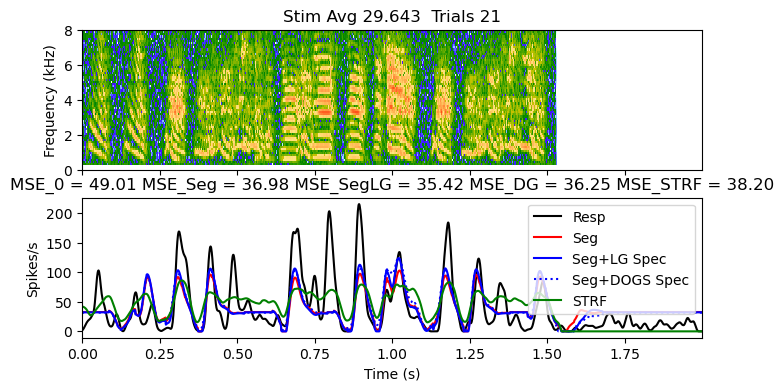

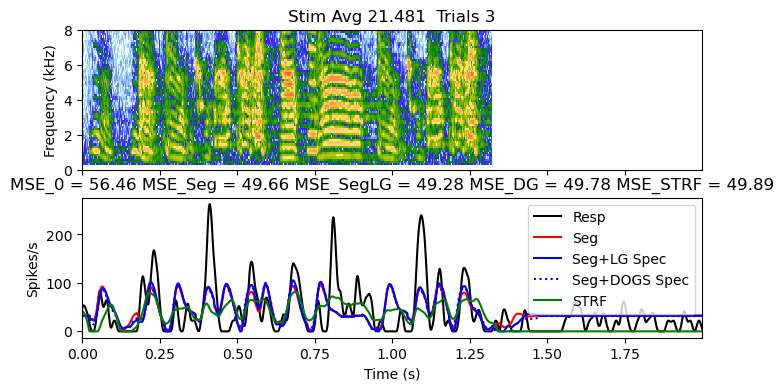

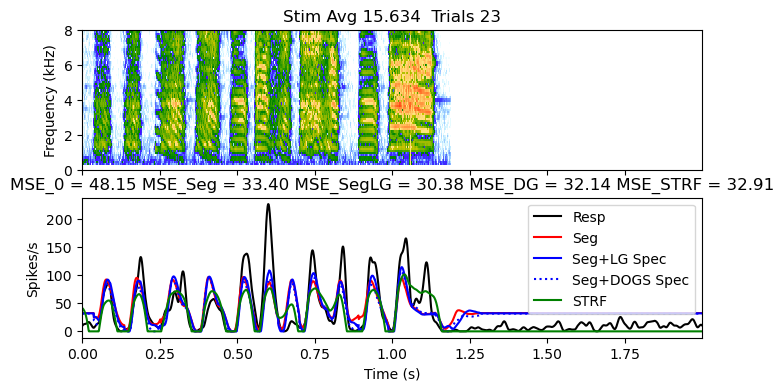

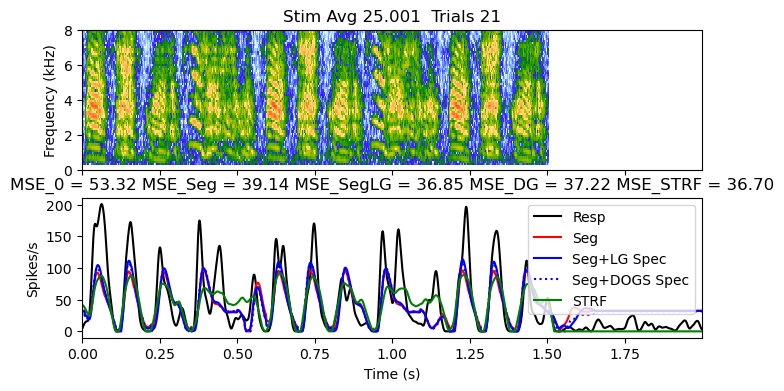

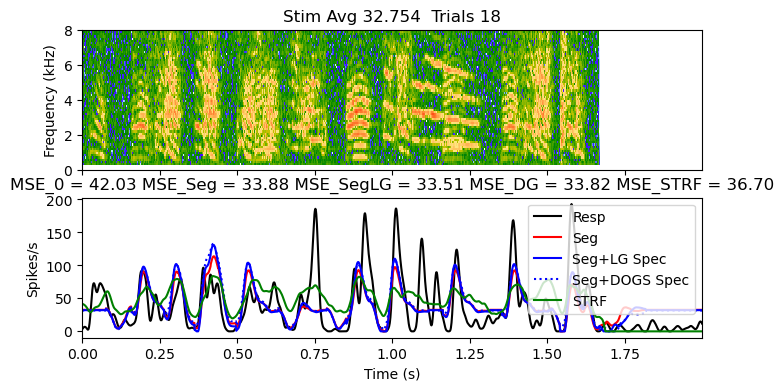

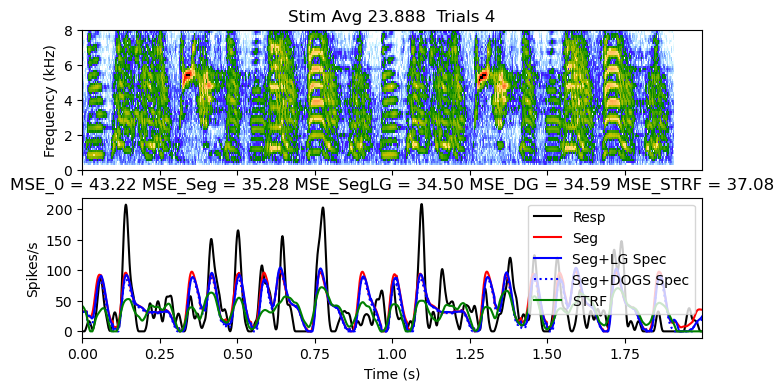

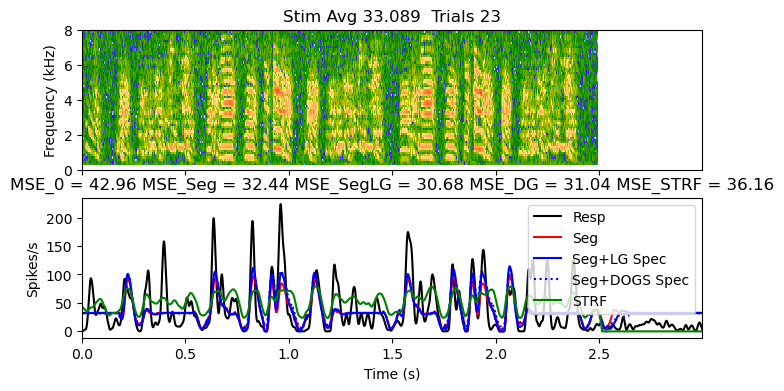

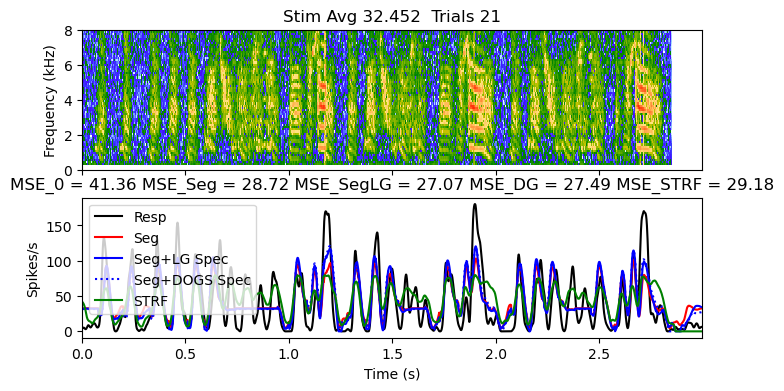

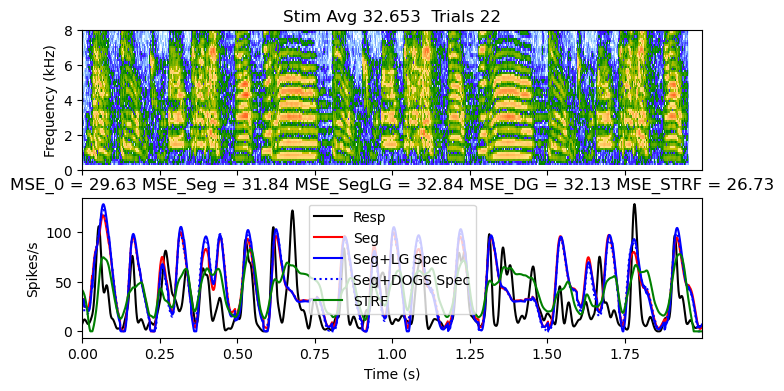

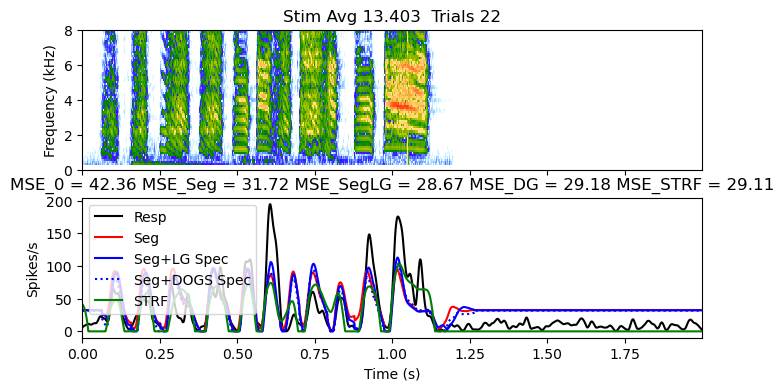

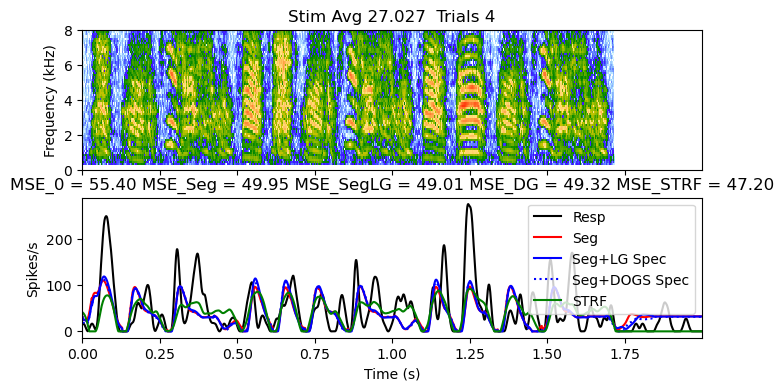

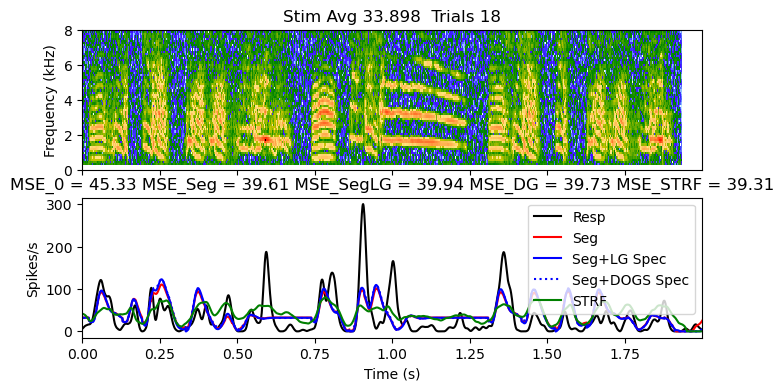

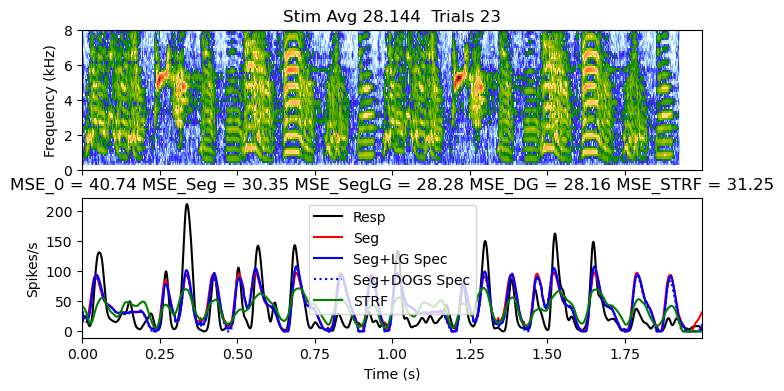

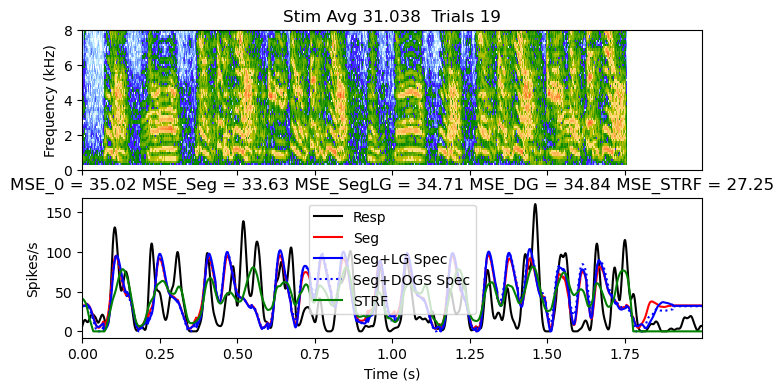

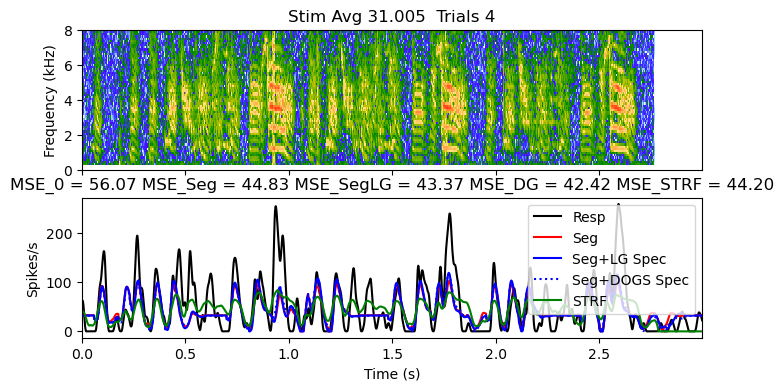

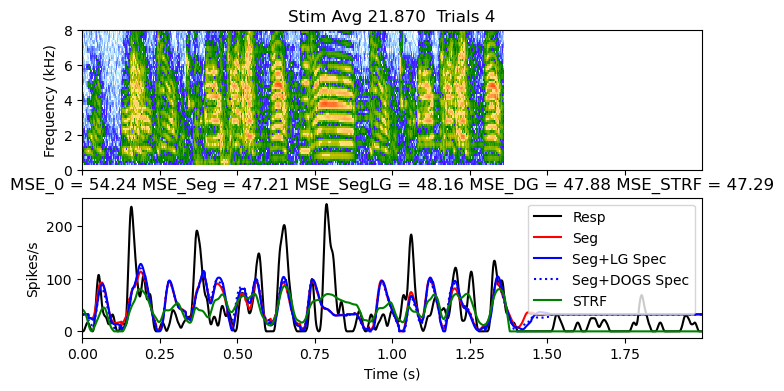

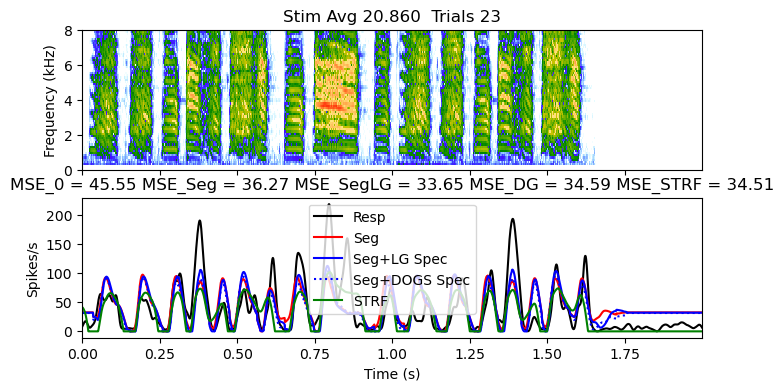

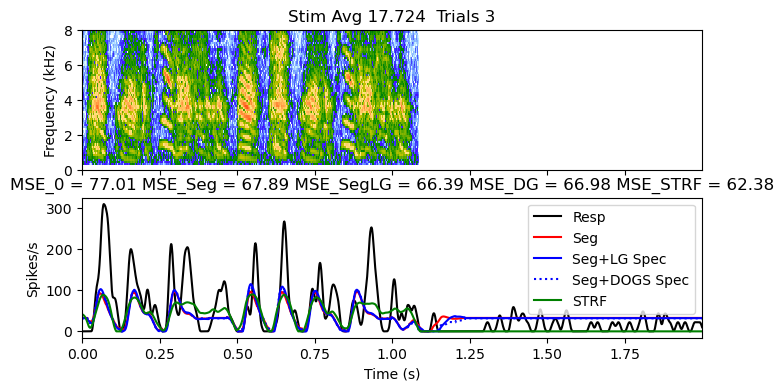

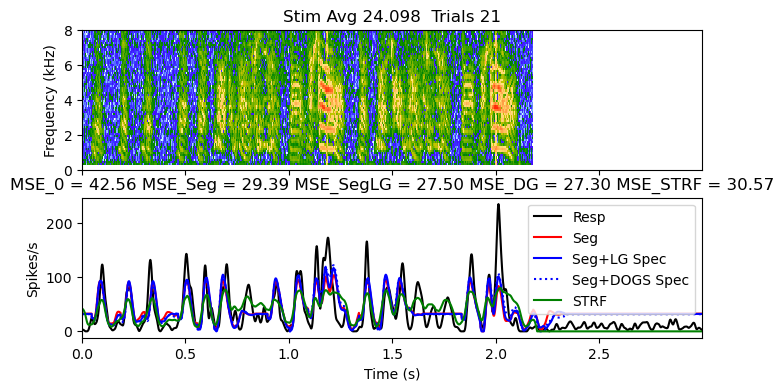

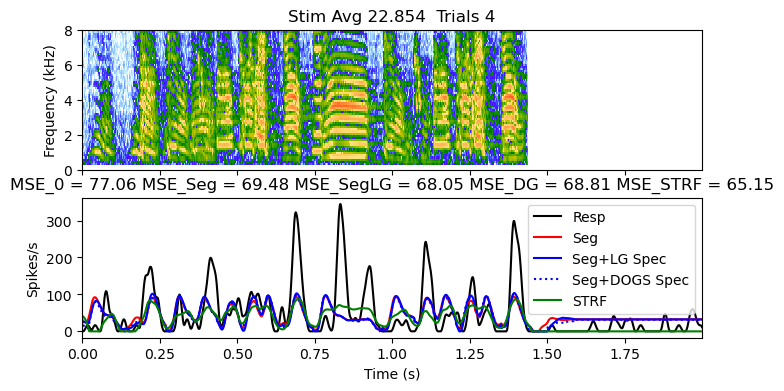

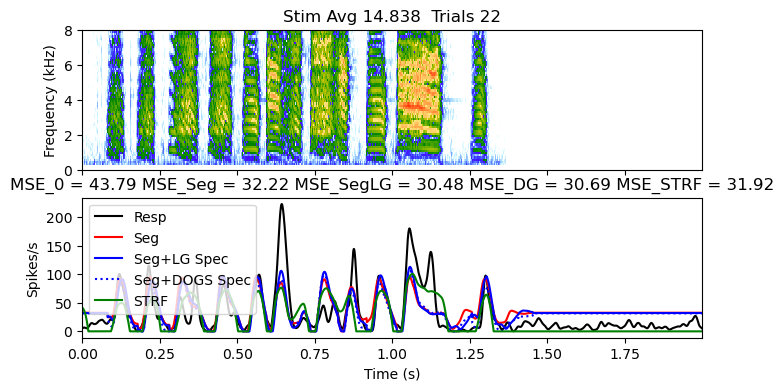

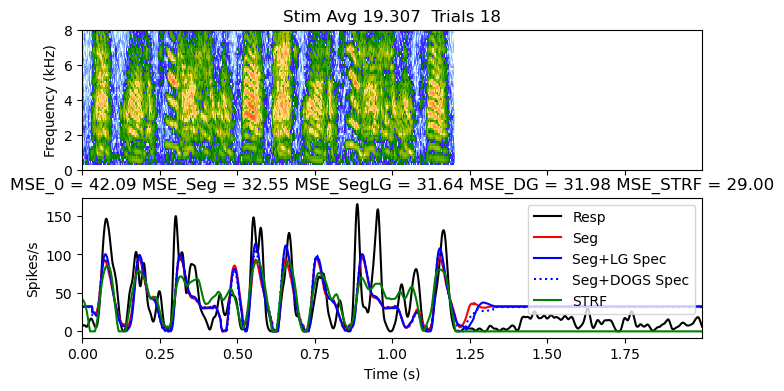

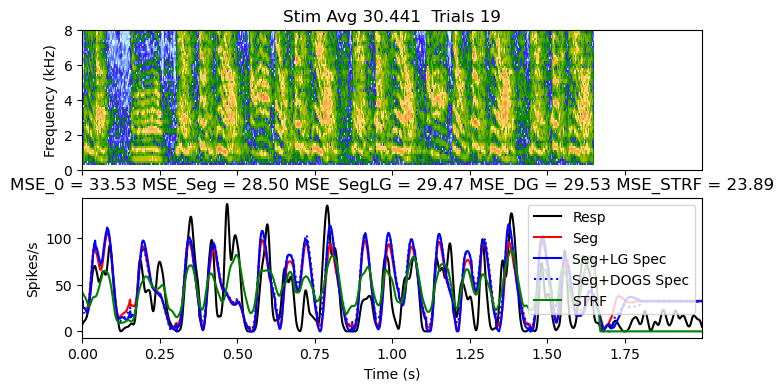

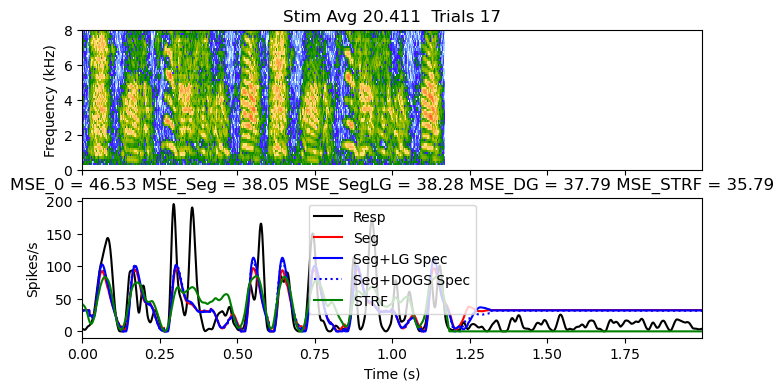

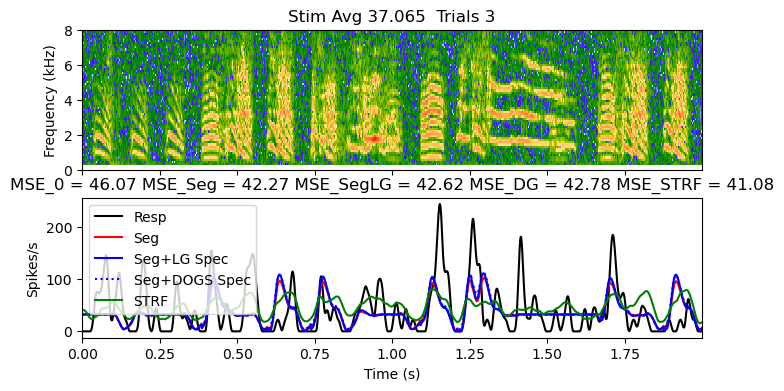

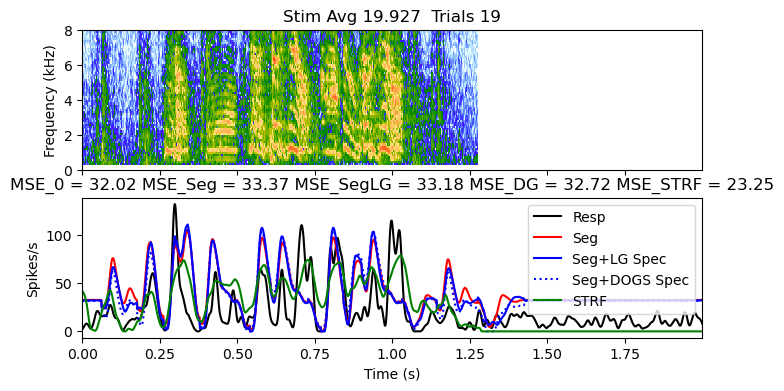

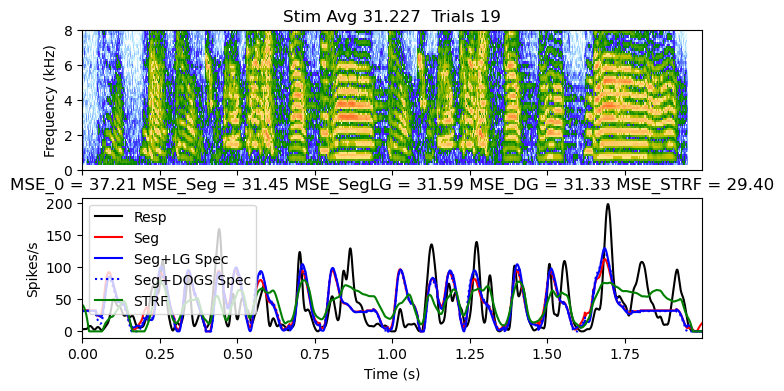

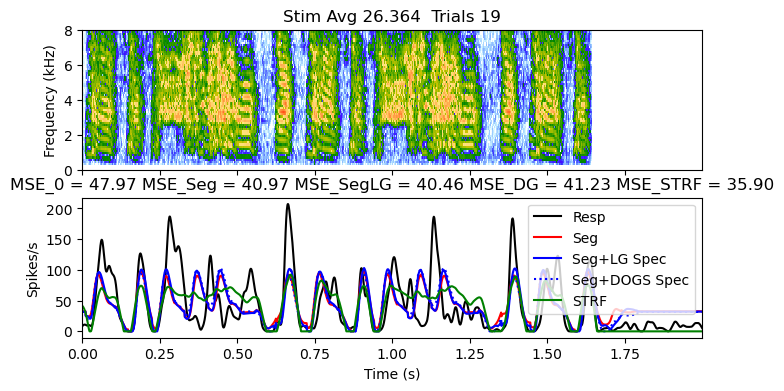

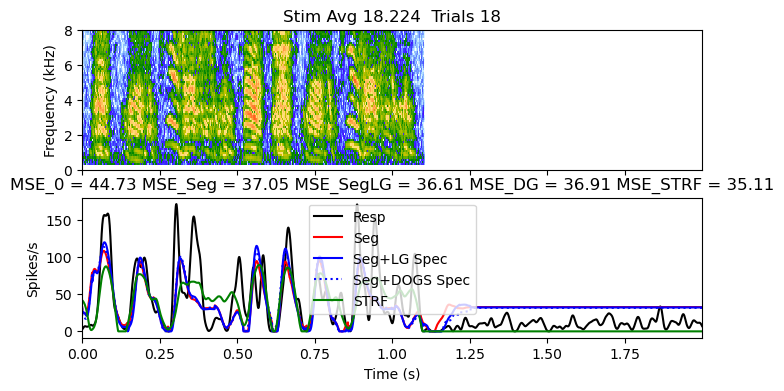

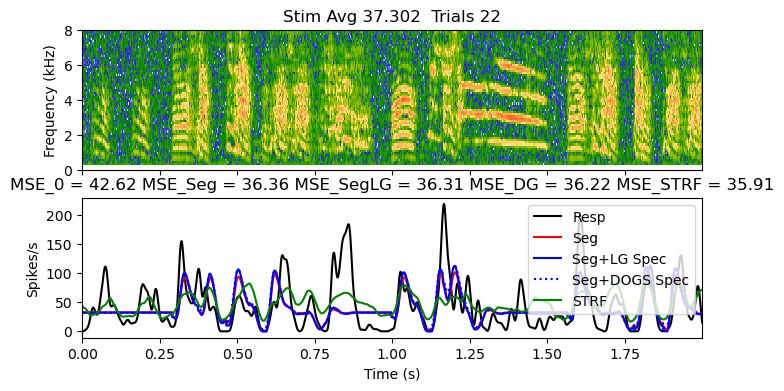

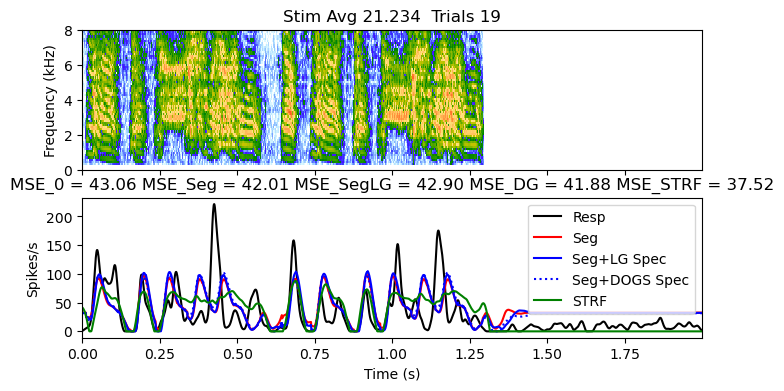

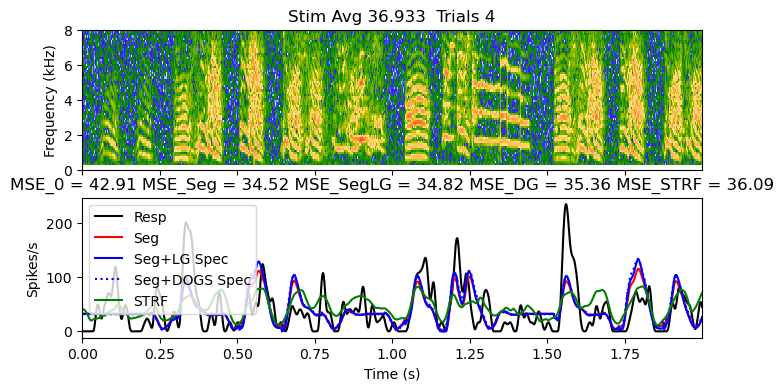

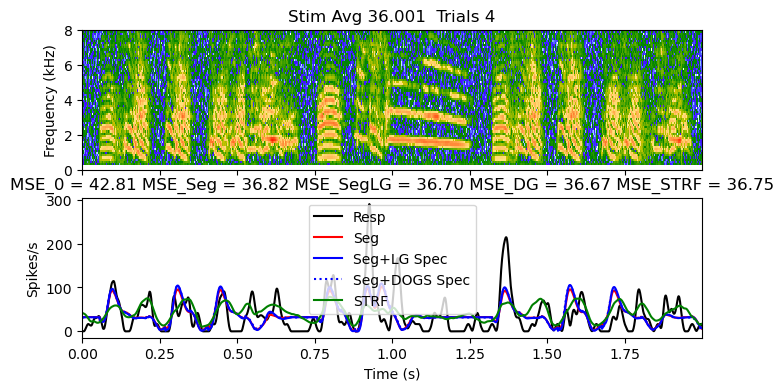

In [61]:
# Show all the results
DBNOISE = 80 # should match value in preprocSound
p = 0
gain = 1.0
for pair in srData['datasets']:

    # Get response (smoothed out psth)
    y = pair['resp']['psth_smooth']
    w = pair['resp']['weights']

    # Get stim and response used by the strf code
    srRange = np.where(globDat['groupIdx'] == p)[0]
    p += 1
    stim = globDat['stim'][srRange, :]
    ystrf = globDat['resp'][srRange]

    mse_0 = np.sqrt(np.sum(((y-segModel['yavg'])**2)*w)/np.sum(w))
    mse_0b = np.sqrt(np.sum(((ystrf-segModel['yavg'])**2)*w)/np.sum(w))

    # get the pred for the segmentation model
    x = calcSegmentedModel.generate_x(pair, event_types, xGen = 'Kernel', nPoints=nPoints)
    y_pred_1 = segModel['weights']@ (x - segModel['xavg']) + segModel['yavg']
    y_pred_1[y_pred_1<0] = 0.0
    mse_1 = np.sqrt(np.sum(((y-y_pred_1)**2)*w)/np.sum(w))
    mse_1b = np.sqrt(np.sum(((ystrf-y_pred_1)**2)*w)/np.sum(w))

    # get the pred for the two segmentation + identification models
    x = calcSegmentedModel.generate_x(pair, feature, basis_args = laguerre_args, xGen = 'LG', nPoints=nPoints, nLaguerre=nLaguerre)   
    y_pred_2 = gain*segIDModelLG['weights']@ (x - segIDModelLG['xavg']) + segIDModelLG['yavg'] + y_pred_1
    y_pred_2[y_pred_2<0] = 0.0
    mse_2 = np.sqrt(np.sum(((y-y_pred_2)**2)*w)/np.sum(w))
    mse_2b = np.sqrt(np.sum(((ystrf-y_pred_2)**2)*w)/np.sum(w))

    x = calcSegmentedModel.generate_x(pair, feature, basis_args = DOGS_args, xGen = 'DG', nPoints=nPoints, nLaguerre=nDOGS)   
    y_pred_3 = gain*segIDModelDG['weights']@ (x - segIDModelDG['xavg']) + segIDModelDG['yavg'] + y_pred_1
    y_pred_3[y_pred_3<0] = 0.0
    mse_3 = np.sqrt(np.sum(((y-y_pred_3)**2)*w)/np.sum(w))
    mse_3b = np.sqrt(np.sum(((ystrf-y_pred_3)**2)*w)/np.sum(w))

    # get the prediction for the classic STRF model
    gindx = np.ones((1, stim.shape[0]))

    y_pred_4 = trnDirectFit.conv_strf(stim-modelParams['stimAvg'], modelParams['delays'], np.real(modelParams['w1']), gindx) + modelParams['b1']
    y_pred_4[y_pred_4<0] = 0.0
    mse_4 = np.sqrt(np.sum(((y-y_pred_4)**2)*w)/np.sum(w))
    mse_4b = np.sqrt(np.sum(((ystrf-y_pred_4)**2)*w)/np.sum(w))

    # The spectrogram
    tfrep = pair['stim']['tfrep']
    minSpect = 0
    maxB = DBNOISE

    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    ax1.set_title('Stim Avg %.3f  Trials %d' % (stim.mean(), w.max()))
    # ax1.set_title('MSE_0 = %.2f MSE_Seg = %.2f MSE_SegLG = %.2f MSE_DG = %.2f MSE_STRF = %.2f' % (mse_0, mse_1, mse_2, mse_3, mse_4))
    # ax1.set_xlabel('Time (s)')

    # The prediction
    numTrials = len(pair['resp']['rawSpikeTimes'])
    # fac = pair['resp']['sampleRate']/numTrials   # The psth and the responses are already normalized in preprocSound.py
    ax2.plot(tfrep['t'], y, 'k', label='Resp')
    # ax2.plot(tfrep['t'], ystrf, 'k:', label='RespSTRF')
    ax2.plot(tfrep['t'], y_pred_1.T, 'r', label='Seg')
    ax2.plot(tfrep['t'], y_pred_2.T, 'b', label='Seg+LG Spec')
    ax2.plot(tfrep['t'], y_pred_3.T, 'b:', label='Seg+DOGS Spec')
    ax2.plot(tfrep['t'], y_pred_4.T, 'g', label='STRF')
    # ax2.plot([tfrep['t'][0], tfrep['t'][-1]], [segModel['yavg'], segModel['yavg']], 'k--', label='Average' )
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    ax2.set_title('MSE_0 = %.2f MSE_Seg = %.2f MSE_SegLG = %.2f MSE_DG = %.2f MSE_STRF = %.2f' % (mse_0, mse_1, mse_2, mse_3, mse_4))
    # ax2.set_title('MSE_0 = %.2f MSE_Seg = %.2f MSE_SegLG = %.2f MSE_DG = %.2f MSE_STRF = %.2f' % (mse_0b, mse_1b, mse_2b, mse_3b, mse_4b))
    plt.legend()




/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_1849/2130095086.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  R2_STRF[ig] = 1 - sse_4/sse_0


Text(0, 0.5, 'R2')

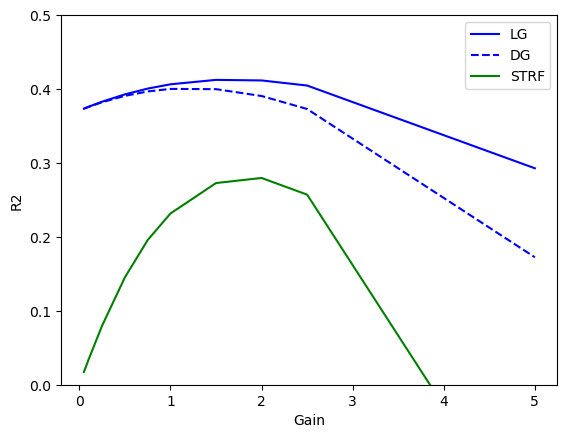

In [47]:
# Show all the results
gainList = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 5.0]
R2_SegLG = np.zeros(len(gainList))
R2_SegDG = np.zeros(len(gainList))
R2_STRF = np.zeros(len(gainList))

for gain in gainList:
    p = 0

sse_0 = 0
sse_1 = 0
s_w = 0
for pair in srData['datasets']:

    y = pair['resp']['psth_smooth']
    w = pair['resp']['weights']
    sse_0 += np.sum(((y-segModel['yavg'])**2)*w)
    s_w += np.sum(w)

    # get the pred for the segmentation model
    x = calcSegmentedModel.generate_x(pair, event_types, xGen = 'Kernel', nPoints=nPoints)
    y_pred_1 = segModel['weights']@ (x - segModel['xavg']) + segModel['yavg']
    y_pred_1[y_pred_1<0] = 0.0
    sse_1 = np.sum(((y-y_pred_1)**2)*w)

for ig, gain in enumerate(gainList):

    p = 0
    sse_2 = 0
    sse_3 = 0
    sse_4 = 0
    for pair in srData['datasets']:

        y = pair['resp']['psth_smooth']
        w = pair['resp']['weights']

        # get the pred for the segmentation model
        x = calcSegmentedModel.generate_x(pair, event_types, xGen = 'Kernel', nPoints=nPoints)
        y_pred_1 = segModel['weights']@ (x - segModel['xavg']) + segModel['yavg']

        # get the pred for the two segmentation + identification models
        x = calcSegmentedModel.generate_x(pair, feature, basis_args = laguerre_args, xGen = 'LG', nPoints=nPoints, nLaguerre=nLaguerre)   
        y_pred_2 = gain*segIDModelLG['weights']@ (x - segIDModelLG['xavg']) + segIDModelLG['yavg'] + y_pred_1
        y_pred_2[y_pred_2<0] = 0.0
        sse_2 += np.sum(((y-y_pred_2)**2)*w)

        x = calcSegmentedModel.generate_x(pair, feature, basis_args = DOGS_args, xGen = 'DG', nPoints=nPoints, nLaguerre=nDOGS)   
        y_pred_3 = gain*segIDModelDG['weights']@ (x - segIDModelDG['xavg']) + segIDModelDG['yavg'] + y_pred_1
        y_pred_3[y_pred_3<0] = 0.0
        sse_3 += np.sum(((y-y_pred_3)**2)*w)

        # get the prediction for the classic STRF model
        srRange = np.where(globDat['groupIdx'] == p)[0]
        p += 1
        stim = globDat['stim'][srRange, :] - modelParams['stimAvg']
        gindx = np.ones((1, stim.shape[0]))

        #compute the prediction for the held out stimulus
        y_pred_4 = gain*trnDirectFit.conv_strf(stim, modelParams['delays'], np.real(modelParams['w1']), gindx) + modelParams['b1']
        y_pred_4[y_pred_4<0] = 0.0
        sse_4 += np.sum(((y-y_pred_4)**2)*w)
    
    R2_SegLG[ig] = 1 - sse_2/sse_0
    R2_SegDG[ig] = 1 - sse_3/sse_0
    R2_STRF[ig] = 1 - sse_4/sse_0

plt.plot(np.array(gainList), R2_SegLG, 'b-', label='LG')
plt.plot(np.array(gainList), R2_SegDG, 'b--', label='DG')
plt.plot(np.array(gainList), R2_STRF, 'g-', label='STRF')
plt.ylim((0, 0.5))
plt.legend()
plt.xlabel('Gain')
plt.ylabel('R2')




In [ ]:
np.argmax(R2_SegDG)

## Repeat with single trials...

In [ ]:
# SINGLE TRIAL 
srData_st = preprocSound.generate_srData_nwb_single_trials(nwb, 'playback_trials',unit.name, balanceFlg=False)
calcSegmentedModel.preprocess_srData(srData_st, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False, seg_spec_lookup = nwb.processing['stimuli_spectrograms'])
print('This playback stim-response data set has %d trials.' % (len(srData_st['datasets'])))

stim_names = []
for ids, ds in enumerate(srData_st['datasets']):
    stim_names.append(ds['stim']['rawFile'])

unique_stims = np.unique(stim_names)

print('There are %d unique stimuli' % len(unique_stims))

In [ ]:
# Calculate mean onset and offet based on single trial data.
meansOnOff_st = np.zeros((2,nPoints))
nEventsOnOff_st = np.zeros((2,1))
responseAvg_st = 0
stimLenTot = 0

for ds in srData_st['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    stimLen = ds['resp']['psth_smooth'].shape[0]
    responseAvg_st += np.sum(ds['resp']['psth_smooth'])
    stimLenTot += stimLen
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]
        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff_st[0,0:endInd-startInd] = meansOnOff_st[0,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff_st[0] += 1
        else:
            meansOnOff_st[1,0:endInd-startInd] = meansOnOff_st[1,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff_st[1] += 1

meansOnOff_st[0,:] /= nEventsOnOff_st[0]
meansOnOff_st[1,:] /= nEventsOnOff_st[1]
responseAvg_st /= stimLenTot

meansOnOff_st[0,:] -= responseAvg_st
meansOnOff_st[1,:] -= responseAvg_st


In [ ]:
# Plot the average responses per-stim versus single trials.

plt.plot(meansOnOff[0,:], 'r', label='Onset PSTH')
plt.plot(meansOnOff[1,:], 'b', label='Offset PSTH')
plt.plot(meansOnOff_st[0,:], 'r--', label='Onset ST')
plt.plot(meansOnOff_st[1,:], 'b--', label='Off ST')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')